In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pycircstat2 import load_data
from pycircstat2.regression import CLRegression

## Circular-Linear Regression

In this section, we replicate the results from Section 6.4 of Fisher (1993), modeling the mean direction of periwinkle movement as a function of distance moved.

In [2]:
df = load_data("B20", source="fisher")
X = df["x"].values[:]
θ = np.deg2rad(df["θ"].values[:])

data_cl = pd.DataFrame({"X": X, "θ": θ})

In [3]:
# Fit the mean direction only model
# This implmentation is ported from R package circular's lm.circular.cl and we arrive at the same results
cl_reg_mean = CLRegression(formula="θ ~ X", model_type="mean", data=data_cl, tol=1e-10)
cl_reg_mean.summary()


Circular Regression for the Mean Direction

Call:
  CLRegression(model_type='mean')

Coefficients for Mean Direction (Beta):

      Estimate     Std. Error   t value    Pr(>|t|)
β0   -0.00832     0.00136      6.12       0.00000     ***

Summary:
  Mean Direction (mu) in radians:
    μ: 2.42597 (SE: 0.11192)

  Concentration Parameter (kappa):
    κ: 3.22430 (SE: 0.71593)

Model Fit Metrics:

Metric       Value       
nLL          -27.76148   
AIC          -53.52296   
BIC          -52.08897   

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
p-values are approximated using the normal distribution.



In [4]:
# Fit the concentration only model
cl_reg_kappa = CLRegression(
    formula="θ ~ X", model_type="kappa", data=data_cl, tol=1e-10
)

cl_reg_kappa.summary()


Circular Regression for the Concentration Parameter

Call:
  CLRegression(model_type='kappa')


Coefficients for Concentration (Gamma):

      Estimate     Std. Error   t value    Pr(>|t|)    
α      -0.25475     0.50585      -0.50      0.61454     
γ0     0.03326      0.00905      3.68       0.00024     ***

Summary:
  Mean Direction (mu) in radians:
    μ: 1.32978 (SE: 0.07460)

  Concentration Parameter (kappa):
    Index    kappa        Std. Error
    [1]      27.23391       6.85109
    [2]       3.58005       0.80650
    [3]       2.32321       0.50677
    [4]       7.19881       1.75046
    [5]      44.85424      11.32782
    [6]       7.69401       1.87768
    [7]       3.24004       0.71988
    [8]       2.10257       0.46255
    [9]       1.15536       0.31770
    [10]       1.78040       0.40459
    [11]       2.65383       0.57893
    [12]       7.69401       1.87768
    [13]       0.91536       0.29398
    [14]      12.25746       3.04289
    [15]       7.44229       1.813

As suggested by Fisher (1993), we use the fitted values from the mean and kappa models as initial values for the mixed model.

In [5]:
beta0 = cl_reg_mean.result["beta"]
gamma0, alpha0 = cl_reg_kappa.result["gamma"], cl_reg_kappa.result["alpha"]

cl_reg_mixed = CLRegression(
    formula="θ ~ X",
    model_type="mixed",
    data=data_cl,
    tol=1e-10,
    beta0=beta0,
    alpha0=alpha0,
    gamma0=gamma0,
)

cl_reg_mixed.summary()


Mixed Circular-Linear Regression

Call:
  CLRegression(model_type='mixed')

Coefficients for Mean Direction (Beta):

      Estimate     Std. Error   t value    Pr(>|t|)
β0   -0.00376     0.00027      13.84      0.00000     ***

Coefficients for Concentration (Gamma):

      Estimate     Std. Error   t value    Pr(>|t|)    
α      -0.41403     0.51485      -0.80      0.42130     
γ0     0.04590      0.00920      4.99       0.00000     ***

Summary:
  Mean Direction (mu) in radians:
    μ: 1.91714 (SE: 0.04552)

  Concentration Parameter (kappa):
    Index    kappa        Std. Error
    [1]      89.82281      22.75070
    [2]       5.46322       1.30087
    [3]       3.00825       0.66257
    [4]      14.32354       3.56887
    [5]     178.80833      45.35346
    [6]      15.70063       3.91924
    [7]       4.76046       1.11638
    [8]       2.62129       0.57155
    [9]       1.14739       0.31683
    [10]       2.08376       0.45894
    [11]       3.61450       0.81540
    [12]     

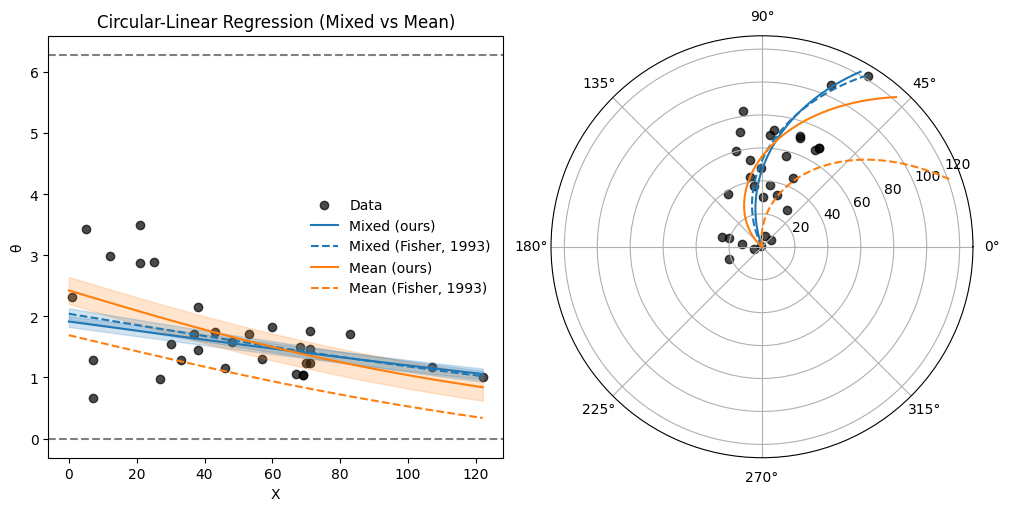

In [6]:
# Compute the mean of X
mean_x = np.mean(X)

# Compute radial deviations from the mean for observed data
radii_data = mean_x + (X - mean_x)

# Compute predicted θ values
predicted_θ = cl_reg_mixed.predict(X[:, None])
X_ = np.linspace(0, X.max(), 100)
fitted_curve_mixed = cl_reg_mixed.predict(X_[:, None])
fitted_curve_mean = cl_reg_mean.predict(X_[:, None])
fitted_curve_fisher_mixed = np.deg2rad(117.1) + 2 * np.arctan(
    X_[:, None] @ np.array([-0.0046])
)
fitted_curve_fisher_mean = np.deg2rad(97.0) + 2 * np.arctan(
    X_[:, None] @ np.array([-0.0066])
)

se_mu_mean = cl_reg_mean.result["se_mu"]  # Standard error of the mean
se_mu_mixed = cl_reg_mixed.result["se_mu"]  # Standard error for mixed model
se_mu_mixed_fisher = 0.0458

# Compute upper and lower bounds for confidence intervals
fitted_curve_mean_upper = fitted_curve_mean + 1.96 * se_mu_mean
fitted_curve_mean_lower = fitted_curve_mean - 1.96 * se_mu_mean

fitted_curve_mixed_upper = fitted_curve_mixed + 1.96 * se_mu_mixed
fitted_curve_mixed_lower = fitted_curve_mixed - 1.96 * se_mu_mixed

fitted_curve_fisher_mixed_upper = fitted_curve_fisher_mixed + 1.96 * se_mu_mixed_fisher
fitted_curve_fisher_mixed_lower = fitted_curve_fisher_mixed - 1.96 * se_mu_mixed_fisher


# Radial position of predicted points: fixed on the mean circle
radii_predicted = mean_x + (X - mean_x)  # Same radial framework as observed data
# Plotting
fig, ax = plt.subplot_mosaic(
    mosaic=[["carte", "polar"]],
    figsize=(10, 5),
    per_subplot_kw={"polar": {"projection": "polar"}},
    constrained_layout=True,
)

# Plot observed data points
ax["polar"].scatter(θ, radii_data, color="black", alpha=0.7, label="Data")

# Plot predicted points on the mean circle
ax["polar"].plot(fitted_curve_mixed, X_, color="C0", label="Mixed (pycircstat2)")
ax["polar"].plot(
    fitted_curve_fisher_mixed,
    X_,
    color="C0",
    linestyle="--",
    label="Mixed (Fisher, 1993)",
)

ax["polar"].plot(fitted_curve_mean, X_, color="C1", label="Mean (pycircstat2)")
ax["polar"].plot(
    fitted_curve_fisher_mean,
    X_,
    color="C1",
    linestyle="--",
    label="Mean (Fisher, 1993)",
)


# Cartesian plot for SE visualization
ax["carte"].scatter(X, θ, color="black", alpha=0.7, label="Data")
ax["carte"].plot(
    X_,
    fitted_curve_mixed,
    color="C0",
    label="Mixed (ours)",
)
ax["carte"].fill_between(
    X_,
    fitted_curve_mixed_lower,
    fitted_curve_mixed_upper,
    color="C0",
    alpha=0.2,
)

ax["carte"].plot(
    X_,
    fitted_curve_fisher_mixed,
    color="C0",
    linestyle="--",
    label="Mixed (Fisher, 1993)",
)

ax["carte"].plot(
    X_,
    fitted_curve_mean,
    color="C1",
    label="Mean (ours)",
)
ax["carte"].fill_between(
    X_,
    fitted_curve_mean_lower,
    fitted_curve_mean_upper,
    color="C1",
    alpha=0.2,
)

ax["carte"].plot(
    X_,
    fitted_curve_fisher_mean,
    color="C1",
    linestyle="--",
    label="Mean (Fisher, 1993)",
)
ax["carte"].fill_between(
    X_,
    fitted_curve_fisher_mixed_lower,
    fitted_curve_fisher_mixed_upper,
    color="C0",
    alpha=0.2,
)


ax["carte"].set_xlabel("X")
ax["carte"].set_ylabel("θ")
ax["carte"].set_title("Circular-Linear Regression (Mixed vs Mean)")
ax["carte"].axhline(0, color="black", linestyle="--", alpha=0.5)
ax["carte"].axhline(2 * np.pi, color="black", linestyle="--", alpha=0.5)
ax["carte"].legend(loc="best", frameon=False)

The results from our implementation of the Mixed Circular-Linear model are quite close to those reported in Fisher (1993), though not exactly the same. We have reason to believe that the numbers reported in the book may not be entirely correct, as the results for the mean direction model were significantly different from both our implementation and the results obtained using R/circular.

## Circular-Circular Regression

In [7]:
from pycircstat2.utils import load_data
from pycircstat2.regression import CCRegression

df = load_data("milwaukee", source="jammalamadaka", print_meta=True)
ctheta = np.deg2rad(df["theta"].values[:])
cpsi = np.deg2rad(df["psi"].values[:])

df_rad = pd.DataFrame({"theta": ctheta, "psi": cpsi})

{
    "Description": "Measurements on wind direction at 6:00 am and 12:00 noon (denoted by θ and φ, respectively), on each of 21 consecutive days, at a weather station in Milwaukee.",
    "Source": "Johnson and Wehrly, 1977",
    "Examples": "Jammalamadaka & SenGupta (2001) Example 8.1",
    "Columns": {
        "theta": {
            "name": "theta",
            "type": "vectors",
            "unit": "degree",
            "notes": "wind direction at 6am"
        },
        "psi": {
            "name": "psi",
            "type": "vectors",
            "unit": "degree",
            "notes": "wind direction at noon"
        }
    }
}


In [8]:
cc = CCRegression(formula="theta ~ psi", data=df_rad)
cc.summary()


Circular-Circular Regression

Circular Correlation Coefficient (rho): 0.51234

Coefficients:
Harmonic     Cosine Coeff   Sine Coeff    
(Intercept)  0.03765        -0.23775      
cos(x1,k=1)  0.47746        -0.28901      
sin(x1,k=1)  0.26616        0.23117       

P-values for Higher-Order Terms:
p1: 0.15187, p2: 0.20656

Higher-order terms are not significant at the 0.05 level.



In [9]:
from pycircstat2.descriptive import circ_kappa

R = np.mean(np.cos(cc.result["residuals"]))
kappa = circ_kappa(R)

print(f"A.k={R}; kappa={kappa}")

A.k=0.4500934560546159; kappa=1.0067620166810398


`CCRegression` is a direct port from R/circular's `lm.circular.cc`, so the result is expected to be the same:

```R
$coefficients
                  [,1]       [,2]
(Intercept) 0.03765164 -0.2377535
cos.x       0.47746346 -0.2890068
sin.x       0.26616458  0.2311712

$p.values[:]
          [,1]      [,2]
[1,] 0.1518748 0.2065554

$A.k
[1] 0.4500935

$kappa
[1] 1.006762

$call
lm.circular.cc(y = ..1, x = ..2, order = 1)

$message
[1] "Higher order terms are not significant at the 0.05 level"

attr(,"class")
[1] "lm.circular.cc"

In [10]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-10-31 11:24:26CET

Python implementation: CPython
Python version       : 3.12.12
IPython version      : 9.6.0

pandas     : 2.3.3
pycircstat2: 0.1.15
matplotlib : 3.10.7
numpy      : 2.3.4

Watermark: 2.5.0

